In [29]:
import pandas as pd
import numpy as np
from  statsmodels.tsa.api import SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error

import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning, ModelWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ModelWarning)

In [65]:
class myHolt:
    def __init__(self, y, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.y0 = y[0]
        self.data = np.zeros(len(y))
        self.data[0] = self.y0
        self.l = np.zeros(len(y))
        self.l[0] = y[0]
        self.b = np.zeros(len(y))
        self.b[0] = 1 if y[1] > y[0] else -1
        
        for i in np.arange(1,len(y)):
            self.calcNextL(i, y[i-1])
            self.calcNextB(i)
            self.data[i] = self.l[i] + self.b[i]
            
    def calcNextL(self, t, val_real):
        l_before = self.l[t-1]
        b_before = self.b[t-1]
        self.l[t] = self.alpha * val_real + (1-self.alpha) * (l_before + b_before) 
          
    def calcNextB(self, t): 
        self.b[t] = self.beta * (self.l[t] - self.l[t-1]) + (1-self.beta) + (1-self.beta)*self.b[t-1]

# IBM HOLT TEST

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-02-01,6.978967,7.087317,6.978967,7.068196,1.577106,674670
1962-02-02,7.068196,7.112811,7.036329,7.112811,1.587062,533460
1962-02-05,7.112811,7.112811,6.985341,7.023582,1.567152,329490
1962-02-06,7.023582,7.036329,6.998088,7.029955,1.568787,274575
1962-02-07,7.036329,7.074570,7.036329,7.036329,1.570211,266730
...,...,...,...,...,...,...
1965-12-06,8.070427,8.102294,7.934990,7.998725,1.791781,1041816
1965-12-07,8.026609,8.142129,8.026609,8.102294,1.814982,407940
1965-12-08,8.134162,8.205864,8.134162,8.150096,1.825689,395388


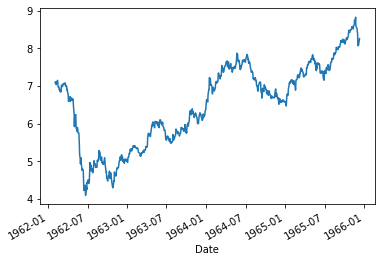

In [48]:
ibm = pd.read_csv('../Lab2/IBM.csv', index_col=['Date'])
ibm.index=pd.to_datetime(ibm.index, format='%d/%m/%Y')
freq = pd.infer_freq(ibm.index)
ibm['High'].plot()
#
ibm

1963-01-01 00:00:00


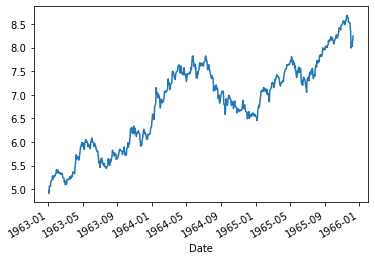

In [42]:
# take the linear part
timestart = datetime.datetime(1963,1,1)
timeend = datetime.datetime(1966,1,1)
print((timestart))
ibm_linear = ibm.loc['1963-01-02':'1966-01-01']
ibm_linear['Open'].plot()

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]

Holt's try to find    0.99
Holt's estimated      1.00
My Holt               0.85
Name: $\alpha$, dtype: float64 Holt's try to find    5.000000e-02
Holt's estimated      1.175507e-13
My Holt               9.900000e-01
Name: $\beta$, dtype: float64 [0.005700217466970596, 0.8500000000000002, 0.9900000000000002]


,Holt's try to find,Holt's estimated,My Holt
$\alpha$,0.990000,1.000000e+00,0.850000
$\beta$,0.050000,1.175507e-13,0.990000
$\phi$,NaN,NaN,NaN
$l_0$,4.911196,4.968435e+00,4.971319
$b_0$,1.007098,1.000580e+00,-1.000000


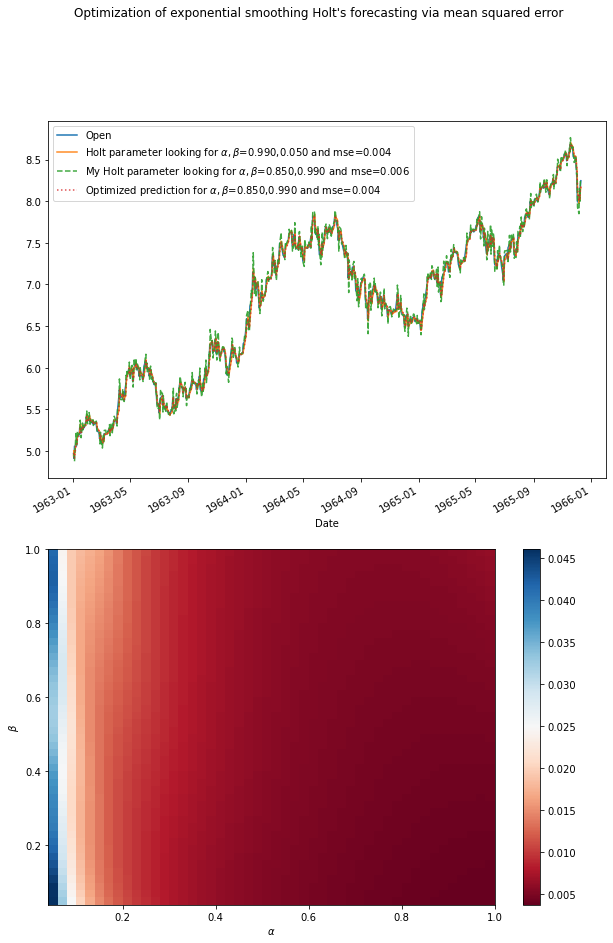

In [71]:
fig, ax = plt.subplots(2, figsize = (10,16))
plt.suptitle("Optimization of exponential smoothing Holt's forecasting via mean squared error")
col = 'Open'
numpy_df = ibm_linear[col].to_numpy()
#print(numpy_df)
best_mse = 1e18
best_mse_mine = [1e18, -1, -1]

bestFit = None
bestFitMine = None

# create grid
start = 0.05
end = 1.0
step = 0.02
param_num =int((end - start)/step) + 1
alphas = np.arange(start, end, step)
betas = np.arange(start, end, step)
y, x = np.meshgrid(alphas, betas)

# take mse's
mses = []
mses_mine = []

l0 = None
b0 = None
# sweep through all alphas
for alpha in alphas:
    for beta in betas:
        # implemented one
        fit = Holt(numpy_df, exponential=True,
                   initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized = False)
        fitted = fit.fittedvalues
        
        # mine
        mHolt = myHolt(numpy_df, alpha, beta)
        l0 = mHolt.l[0]
        b0 = mHolt.b[0]
        fitMine = mHolt.data

        # calculate mse's
        mse = mean_squared_error(fitted, numpy_df)
        mseMine = mean_squared_error(fitMine, numpy_df)
        
        mses.append(mse)
        mses_mine.append(mseMine)
        #print(r"For $\alpha =$"+ f"{alpha:.3f}" "and $\beta =$"+ f"{beta:.3f} the mse is {mse:.3f}")    
        if mse < best_mse: 
            best_mse = mse
            bestFit = fit   
        if mseMine < best_mse_mine[0]: 
            best_mse_mine = [mseMine, alpha, beta]
            bestFitMine = fitMine       
        
# make optimized prediction from the library
fit = Holt(ibm_linear[col], exponential=True, initialization_method="estimated",).fit()  
m=mean_squared_error(np.array(fit.fittedvalues), numpy_df)


# plot the results 
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$"],
    columns=["Holt's try to find", "Holt's estimated"],
)

results["Holt's try to find"] = [bestFit.params[p] for p in params] 
results["Holt's estimated"] = [fit.params[p] for p in params] 
results["My Holt"] = [best_mse_mine[1], best_mse_mine[2], np.nan, l0, b0]
alphas = results.iloc[0]
betas = results.iloc[1]
print(alphas,betas, best_mse_mine)
# plot 
#ax[0].plot(ibm_linear.index, numpy_df, label = 'original data')
ibm_linear[col].plot(ax=ax[0])
ax[0].plot(ibm_linear[col].index, bestFit.fittedvalues, '-', alpha=0.9,
           label = r'Holt parameter looking for $\alpha,\beta$=' + f'{alphas[0]:.3f},{betas[0]:.3f} and mse={best_mse:.3f}')
ax[0].plot(ibm_linear[col].index, fitMine, '--', alpha=0.9,
           label = r'My Holt parameter looking for $\alpha,\beta$=' + f'{best_mse_mine[1]:.3f},{best_mse_mine[2]:.3f} and mse={best_mse_mine[0]:.3f}')
ax[0].plot(ibm_linear[col].index, fit.fittedvalues, ':', alpha=0.8, label = r'Optimized prediction for $\alpha,\beta$=' + f'{alphas[-1]:.3f},{betas[-1]:.3f} and mse={m:.3f}')
ax[0].legend()

c = ax[1].pcolormesh(x, y, np.array(mses).reshape((param_num, param_num)), cmap='RdBu', vmin=np.min(mses), vmax=np.max(mses), shading='auto')
fig.colorbar(c, ax = ax[1])
#ax[1].plot(alphas, mses_stat, label = 'from statsmodel')
#ax[1].plot(alphas, mses_mine, label = 'from mymodel')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel(r"$\beta$")
#ax[1].set_zlabel(r"Holt mse")
#ax[1].set_title(r"Model parameter $\alpha$ optimization")
results